# SPAtial EFficiency metric
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __24/01/2020__

__Introducción__<br>
Se genera el código para aplicar la métrica de rendimiento de un modelo hidrólogico SPAEF [(Koch et al., 2018)](https://www.geosci-model-dev.net/11/1873/2018/). Es una función objetivo que analiza espacialmente el rendimiento del modelo y que emula la lógica detrás del criterio KGE (Kling-Gupta efficiency) [(Gupta et al., 2009)](https://www.sciencedirect.com/science/article/pii/S0022169409004843), utilizado habitualmente para el caudal.

$$SPAEF=1-\sqrt{(\alpha-1)^2+(\beta-1)^2+(\gamma-1)^2}$$
Donde $\alpha$ es el coeficiente de correlación de Pearson, $\beta$ el cociente entre los coeficientes de variación (representativo de la variabilidad espacial), y $\gamma$ es la intersección entre los histogramas normalizados del patrón observado ($K$) y del patrón simulado ($L$):
$$\alpha=\rho(obs,sim)
\;,\;\;
\beta=\frac{\frac{\sigma_{sim}}{\mu_{sim}}}{\frac{\sigma_{obs}}{\mu_{obs}}}
\;,\;\;
\gamma=\frac{\sum_{j=1}^{n}min(K_j,L_j)}{\sum_{j=1}^{n}K_j}$$

Como caso de estudio al que aplicar el código se utilizan los resultados de la simulación de la evapotranspiración en la cuenca alta del río Deva.

<font color='indianred'>__Limitación__: compara el acuerdo entre dos mapas, no entre dos series de mapas. Es decir, hay que obtener un mapa medio representativo de la variable. </font>

__Cosas que arreglar__ <br>

***

__Índice__ <br>
__[0 Configuración](#0-Configuración)__<br>

__[1 Sesgo](#1-Sesgo)__<br>
[1.1 Resultados SCEUA](#1.1-Resultados-SCEUA)<br>

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from netCDF4 import Dataset
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'
print(rutaBase)

F:/Codigo/GitHub/Calibrar/docs/


In [2]:
os.chdir(rutaBase + '..')
from read_write import read_ascii, write_ascii

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.style.use('dark_background')
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set()
custom_style = {'axes.facecolor': 'k',
                'axes.edgecolor': 'gray',
                'axes.labelcolor': 'white',
                'figure.facecolor': 'k',
                'grid.color': 'gray',
                'text.color': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                "xtick.major.size": 0,
                "ytick.major.size": 0}
sns.set_style(style='darkgrid', rc=custom_style)

***
## Configuración

In [4]:
var = 'ET'

***
## Cargar datos
#### MODIS

In [5]:
# fijar ruta y nombre del archivo
rutaMODIS = rutaBase + '../../MODIS/output/' + var + '/'
filename = 'MODIS_' + var + '_ArcGIS.nc'

In [6]:
# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaMODIS + filename, 'r', format='NETCDF4')

# extraer datos en un diccionario
Data = {}
for sat in ['Terra', 'Aqua']:
    Data[sat] = {}
    # evapotranspiración
    Data[sat][var] = ncRead[sat][var][::].data
    # fechas
    Data[sat]['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead[sat]['time'][:]]
    # coordenadas
    Data[sat]['X'] = ncRead[sat]['X'][:].data
    Data[sat]['Y'] = ncRead[sat]['Y'][:].data

ncRead.close()

In [7]:
print('Terra:\t{0}'.format(Data['Terra'][var].shape))
print('Aqua:\t{0}'.format(Data['Aqua'][var].shape))

Terra:	(840, 46, 47)
Aqua:	(774, 46, 47)


Voy a utilizar los datos de __Terra__ porque comienzan antes y, por tanto, tienen mayor solape con el periodo de simulación en TETIS.

In [8]:
del Data['Aqua']

#### TETIS

In [9]:
# fijar rutas y nombre del archivo
rutaData = rutaBase + '../data/'
filename = 'TETIS_' + var + '.nc'

In [10]:
if os.path.exists(rutaData + filename) == False:

    # IMPORTAR ASCII DE TETIS
    # -----------------------
    # ruta del proyecto TETIS
    rutaTETIS = 'F:/Proyectos/GESDIVAH/SDM/TETIS/PdE/Actual/Bias/'

    # lista de archivos con los resultados
    os.chdir(rutaTETIS + '_ASCII/')
    files = [file for file in os.listdir() if file[-3:] == 'asc']

    # cargar archivos ascii con los resultados de TETIS
    for i, file in enumerate(files):
        print('archivo {0:>3} de {1}: {2}'.format(i+1, len(files), file), end='\r')
        # leer archivo ascii
        read_ascii(file)
        if i == 0:
            Datatetis = read_ascii.data
            atrsTetis = read_ascii.attributes
        else:
            Datatetis = np.dstack((Datatetis, read_ascii.data))    

    # transformar 'Datatetis' para que la primera dimensión sea el tiempo
    Datatetis = np.moveaxis(Datatetis, 2, 0)
    
    # guardar en un diccionario
    TETISdict = {}
    TETISdict[var] = Datatetis
    del Datatetis

    # fechas de cada mapa
    datesStr = [file.split('_')[1].split('.')[0][:8] for file in files]
    TETISdict['dates'] = [datetime(int(date[:4]), int(date[4:6]), int(date[6:8])).date() for date in datesStr]
    del datesStr

    # coordenadas
    TETISdict['X'] = np.arange(atrsTetis[2], atrsTetis[2] + atrsTetis[0] * atrsTetis[4],
                                 atrsTetis[4])
    TETISdict['Y'] = np.arange(atrsTetis[3], atrsTetis[3] + atrsTetis[1] * atrsTetis[4],
                                 atrsTetis[4])

    # GENERAR NETCDF
    # --------------
    # definir el netcdf
    if os.path.exists(rutaBase + '../data/') == False:
        os.makedirs(rutaBase + '../data/') # crear carpeta donde guardarlo
    ncTETIS = Dataset(rutaData + filename, 'w', format='NETCDF4')

    # crear atributos
    ncTETIS.description = 'Serie temporal de mapas de evapotranspiración simulados con TETIS de la cuenca del Deva'
    ncTETIS.history = 'Creado el ' + datetime.now().date().strftime('%Y-%m-%d')
    ncTETIS.coordinateSystem = 'epsg:25830' # ETRS89 30N

    # crear las dimensiones
    time = ncTETIS.createDimension('time', len(TETISdict['dates']))
    Y = ncTETIS.createDimension('Y', len(TETISdict['Y']))
    X = ncTETIS.createDimension('X', len(TETISdict['X']))

    # crear variables
    data = ncTETIS.createVariable(var, 'f4', ('time', 'Y', 'X'))
    data.units = 'mm/8días'
    times = ncTETIS.createVariable('time', 'f8', ('time',))
    times.units = 'días desde el 0001-01-01'
    times.calendar = 'Gregoriano'
    Xs = ncTETIS.createVariable('X', 'u4', ('X',))
    Xs.units = 'm'
    Ys = ncTETIS.createVariable('Y', 'u4', ('Y',))
    Ys.units = 'm'

    # variable
    data[:,:,:] = TETISdict[var][:,:,:]
    # variable 'time'
    deltas = [date - datetime(1, 1, 1).date() for date in TETISdict['dates']]
    times[:] = [delta.days for delta in deltas]
    # variable 'X'
    Xs[:] = TETISdict['X']
    # variable 'Y'
    Ys[:] = TETISdict['Y']

    ncTETIS.close()

In [11]:
# IMPORTAR NETCDF
# ---------------
# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaData + filename, 'r', format='NETCDF4')
# extraer datos en un diccionario
Data['TETIS'] = {}
# evapotranspiración
Data['TETIS'][var] = ncRead[var][::].data
# fechas
Data['TETIS']['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead['time'][:]]
# coordenadas
Data['TETIS']['X'] = ncRead['X'][:].data.astype('int')
Data['TETIS']['Y'] = ncRead['Y'][:].data.astype('int')
# cerrar conexión
ncRead.close()

### Seleccionar periodo de estudio
Se seleccionan los datos correspondientes al periodo en el que ambas fuentes (Terra y TETIS) tienen datos.

In [12]:
dateMin = max(Data['Terra']['dates'][0], Data['TETIS']['dates'][0]).date()
dateMax = min(Data['Terra']['dates'][-1], Data['TETIS']['dates'][-1]).date()
print('fecha de inicio:\t{0}\nfecha de fin:\t\t{1}'.format(dateMin, dateMax))

fecha de inicio:	2001-01-01
fecha de fin:		2004-09-26


In [13]:
# recortar datos a las fechas de inicio y fin
for src in ['Terra', 'TETIS']:
    print(src)
    # seleccionar datos de Terra dentro de las fechas de inicio y fin
    datesSrc = np.array([d.date() for d in Data[src]['dates']])
    mask = (datesSrc >= dateMin) & (datesSrc <= dateMax)
    Data[src]['dates'] = datesSrc[mask]
    print('nº de fechas:\t{0}'.format(len(Data[src]['dates'])))

    # recortar los mapas dentro de las fechas de inicio y fin
    Data[src][var] = Data[src][var][mask, :, :]
    print('dimensiones:\t{0}'.format(Data[src][var].shape))

    del datesSrc, mask
    print()

Terra
nº de fechas:	171
dimensiones:	(171, 46, 47)

TETIS
nº de fechas:	171
dimensiones:	(171, 216, 222)



#### Unificar resolución de los mapas
<font color='indianred'>¿Es mejor aumentar la resolución de MODIS o reducir la de TETIS?</font><br>
Genero una nueva fuente (primera 'key' del diccionario) en la que guardar los resultados de TETIS remuestreados para concordar con la resolución de los mapas de MODIS.

In [15]:
# resolución de MODIS
resMODIS = 463.3127165275

In [16]:
Data['TETIS_'] = {}
Data['TETIS_'][var] = np.ones((Data['Terra'][var].shape)) * np.nan

# hacer la media sobre una ventana móvil de 5x5 celdas
for i, y in enumerate(Data['Terra']['Y']):
    for j, x in enumerate(Data['Terra']['X']):
        maskY = np.where(abs(Data['TETIS']['Y'] - y) < resMODIS / 2)[0]
        maskX = np.where(abs(Data['TETIS']['X'] - x) < resMODIS / 2)[0]
#         print('i: {0}\tj: {1}\tdimensiones de la máscara: ({2},{3})'.format(i, j, len(maskY),
#                                                                             len(maskX)), end='\r')
        Data['TETIS_'][var][:,i,j] = np.nanmean(Data['TETIS'][var][:,maskY,:][:,:,maskX], axis=(1,2))

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [17]:
# guardar resto de variables
Data['TETIS_']['dates'] = Data['TETIS']['dates']
Data['TETIS_']['X'] = Data['Terra']['X']
Data['TETIS_']['Y'] = Data['Terra']['Y']

In [18]:
for src in ['Terra', 'TETIS_']:
    print(src)
    print('dimensiones:\t{0}'.format(Data[src][var].shape))

Terra
dimensiones:	(171, 46, 47)
TETIS_
dimensiones:	(171, 46, 47)


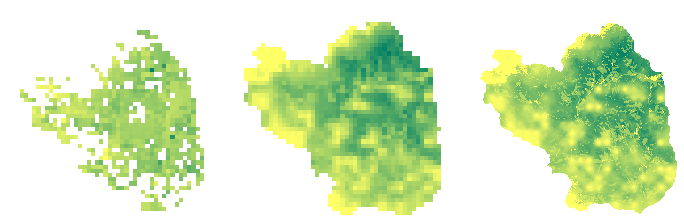

In [25]:
t = 40

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for ax, src in zip(axes, ['Terra', 'TETIS_', 'TETIS']):
    ax.imshow(Data[src][var][t,:,:], cmap='summer_r')
    ax.axis('off')
    ax.set_title(src, fontsize=13, fontweight='bold')

***
## Análisis
### Evapotranspiración media

In [ ]:
np.nanmax((Data['TETIS'][var]))

In [ ]:
np.nanmax((Data['Terra'][var]))

In [ ]:
# mapas medios del periodo
for src in ['Terra', 'TETIS']:
    Data[src][var + '_'] = np.nanmean(Data[src][var], axis=0)

In [ ]:
plotMODISseries(Data, var, 'dates', r=10, src=['TETIS', 'Terra'])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.subplots_adjust(right=0.9)

r = 10
vmin = np.floor(min(np.nanmin(Data['TETIS'][var + '_']),
                    np.nanmin(Data['Terra'][var + '_'])) / r) * r
vmax = np.ceil(max(np.nanmax(Data['TETIS'][var + '_']),
                   np.nanmax(Data['Terra'][var + '_'])) / r) * r
cmap = 'summer_r'

for ax, src in zip(axes, ['TETIS', 'Terra']):
    im = ax.imshow(Data[src][var + '_'], cmap='summer_r')
    ax.set_title(src, fontsize=13)
    ax.axis('off')
    
cbar_ax = fig.add_axes([0.925, 0.3, 0.01, 0.4])
cbar_ax.tick_params(labelsize=12)
cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
cb.set_label('mm/8 días', fontsize=14)
    
fig.text(0.5, .92, var + ' media', fontsize=15, fontweight='bold', horizontalalignment='center');

In [ ]:
np.nanmax(Data['Terra']['ET'])

In [ ]:
plotMODISseris(Data, var, 'dates', 10, src=['Terra', 'TETIS'], ymin=0, ylabel=var + ' (mm)')

In [ ]:
ymin=None
ylabel=None
lw=.25
alpha=.1

In [ ]:
# mostrar la serie 8-diaria para cada celda y la media de la cuenca
fig, axes = plt.subplots(nrows=2, figsize=(15, 7), sharex=True)

xlim = [min(min(Data['Terra']['dates']), min(Data['TETIS']['dates'])),
        max(max(Data['Terra']['dates']), max(Data['TETIS']['dates']))]
ymin = 0
ymax = np.ceil(max([np.nanmax(Data[sat][var]) for sat in Data.keys()]) / r) * r
colors = [['yellowgreen', 'darkolivegreen'], ['lightsteelblue', 'steelblue']]

for c, (ax, sat) in enumerate(zip(axes, ['Terra', 'TETIS'])):
    timex, datax = Data[sat]['dates'], Data[sat][var]
    for i in range(datax.shape[1]):
        for j in range(datax.shape[2]):
            if np.all(np.isnan(datax[:,i,j])): # celda vacía
                continue
            else:
                # serie de una celda
                ax.plot(timex, datax[:, i,j], lw=lw, c=colors[c][0], alpha=alpha)
    # serie media areal
    ax.plot(timex, np.nanmean(datax, axis=(1, 2)), c=colors[c][1], lw=4*lw)
    # configuración
    ax.tick_params(labelsize=11)
    ax.set(xlim=xlim, ylim=(ymin, ymax))
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(sat, fontsize=13, fontweight='bold');

In [ ]:
i, j = 0, 0

In [ ]:
np.all(np.isnan(datax[:,i,j]))

In [ ]:
if ymin == True:
    ymin = np.floor(min([np.nanmin(data[sat][var]) for sat in data.keys()]) / r) * r
else:
    ymin = 0
ymax = np.ceil(max([np.nanmax(data[sat][var]) for sat in data.keys()]) / r) * r
colors = [['yellowgreen', 'darkolivegreen'], ['lightsteelblue', 'steelblue']]

for c, (ax, sat) in enumerate(zip(axes, ['Terra', 'Aqua'])):
    timex, datax = data[sat][timevar], data[sat][var]
    for i in range(datax.shape[1]):
        for j in range(datax.shape[2]):
            if np.all(np.isnan(datax[:,i,j])): # celda vacía
                continue
            else:
                # serie de una celda
                ax.plot(timex, datax[:, i,j], lw=lw, c=colors[c][0], alpha=alpha)
    # serie media areal
    ax.plot(timex, np.nanmean(datax, axis=(1, 2)), c=colors[c][1], lw=4*lw)
    # configuración
    ax.tick_params(labelsize=11)
    ax.set(xlim=xlim, ylim=(ymin, ymax))
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(sat, fontsize=13, fontweight='bold');

1. <font color='steelblue'>Generar mapas medios</font>. Probaría inicialmente con un mapa medio de junio, al igual que hace Koch (2018).
2. <font color='steelblue'>Normalizar mapas</font>. Necesario para comparar dos mapas que puedan tener diferentes magnitudes
3. <font color='steelblue'>Hacer coincidir la resolución espacial</font>. Seguramente sea mejor suavizar el mapa de mayor resolución (TETIS) para acomodarse al de menor resolución (MODIS).
4. <font color='steelblue'>Analizar SPAEF</font>

<font color='indianred'>¡UNIDADES DE MODIS!</font>

#### 1 Generar mapas medios
__TETIS__

In [ ]:
# evapotranspiración media en junio
mask = np.array([d.month == 6 for d in datesTetis])
print('nº de mapas en junio: {0}'.format(mask.sum()))
meanTETIS = np.nanmean(ETtetis[mask,:,:], axis=0)

__Terra__

In [ ]:
# evapotranspiración media en junio
mask = np.array([d.month == 6 for d in datesTerra])
print('nº de mapas en junio: {0}'.format(mask.sum()))
meanTerra = np.nanmean(ETterra[mask,:,:], axis=0).data

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.subplots_adjust(right=0.9)

r = 10
vmin = np.floor(min(np.nanmin(meanTETIS), np.nanmin(meanTerra)) / r) * r
vmax = np.ceil(max(np.nanmax(meanTETIS), np.nanmax(meanTerra)) / r) * r
cmap = 'summer_r'

for ax, data, title in zip(axes, [meanTETIS, meanTerra], ['TETIS', 'Terra']):
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=13)
    ax.axis('off')
    
cbar_ax = fig.add_axes([0.925, 0.3, 0.01, 0.4])
cbar_ax.tick_params(labelsize=12)
cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
cb.set_label('mm/mes', fontsize=14)
    
fig.text(0.5, .92, 'ET media junio', fontsize=15, fontweight='bold', horizontalalignment='center');

<font color='indianred'>A simple vista se observa un gran __sesgo__ entre el mapa simulado y el mapa de MODIS</font>. Mientras que el mapa de MODIS otorga valores de hasta 50 mm de ET en el mes de junio, el mapa simulado no pasa de los 10 mm. Para demostrar este sesgo, se muestran más abajo el resumen estadístico (cuantiles, media y desviación típica) de ambos mapas.

Si se ajustan por separado las leyendas de los dos mapas, se observa que la variabilidad del mapa simulado es muy superior a la del mapa de MODIS, y que los patrones espaciales de ambos mapas no corresponden

In [ ]:
print('Resumen del mapa medio de junio de TETIS')
print('min = {0:.1f}\tmedian = {1:.1f}\tmax = {2:.1f}\tmean = {3:.1f}\tstd = {4:.1f}'.format(np.nanmin(meanTETIS),
                                                                                             np.nanmedian(meanTETIS),
                                                                                             np.nanmax(meanTETIS),
                                                                                             np.nanmean(meanTETIS),
                                                                                             np.nanstd(meanTETIS)), end='\n\n')

print('Resumen del mapa medio de junio de Terra')
print('min = {0:.1f}\tmedian = {1:.1f}\tmax = {2:.1f}\tmean = {3:.1f}\tstd = {4:.1f}'.format(np.nanmin(meanTerra),
                                                                                             np.nanmedian(meanTerra),
                                                                                             np.nanmax(meanTerra),
                                                                                             np.nanmean(meanTerra),
                                                                                             np.nanstd(meanTerra)), end='\n\n')

#### Normalizar mapas
En el caso de la evapotranspiración, lo correcto no sería normalizar los datos, puesto que coinciden la variable y unidades de salida de TETIS con las de MODIS. Corregir los mapas supone obviar el sesgo comentado anteriormente, lo cual no es correcto. Sin embargo, en este ejemplo de prueba voy a normalizar los mapas para poder analizar el acuerdo entre histogramas.

#### Superponer mapas

In [ ]:
xTerra = ET['Terra']['X'].data
yTerra = ET['Terra']['Y'].data

print('Limites mapa de Terra')
print('esquina inf. izda.: ({0},{1})'.format(xTerra[0], yTerra[-1]))
print('esquina sup. dcha.: ({0},{1})'.format(xTerra[-1], yTerra[0]))

In [ ]:
xTetis = np.arange(atrsTetis[2], atrsTetis[2] + atrsTetis[4] * atrsTetis[0], atrsTetis[4])
yTetis = np.arange(atrsTetis[3], atrsTetis[3] + atrsTetis[4] * atrsTetis[1], atrsTetis[4])[::-1]

print('Limites mapa de TETIS')
print('esquina inf. izda.: ({0},{1})'.format(xTetis[0], yTetis[-1]))
print('esquina sup. dcha.: ({0},{1})'.format(xTetis[-1], yTetis[0]))

In [ ]:
plt.figure(figsize=(12, 5))

plt.imshow(meanTETIS, extent=[xTerra[0], xTerra[-1], yTerra[-1], yTerra[0]])
plt.imshow(meanTerra, extent=[xTetis[0], xTetis[-1], yTetis[-1], yTetis[0]], cmap='summer_r', alpha=.7)
plt.axis('off');

In [ ]:
# exportar ASCII de los mapas medios
atrsTerra = [meanTerra.shape[1], meanTerra.shape[0], xTerra[0], yTerra[-1], 500, -9999.0]
temp = meanTerra.copy()
temp[np.isnan(temp)] = atrsTerra[5]
write_ascii(rutaBase + '../output/Terra-meanETjune', temp, atrsTerra, format='%.1f ', epsg='25830')
del temp

In [ ]:
temp = meanTETIS.copy()
temp[np.isnan(temp)] = atrsTetis[5]
write_ascii(rutaBase + '../output/TETIS-meanETjune', temp, atrsTetis, format='%.1f ', epsg='25830')
del temp